In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
p_match = pd.read_csv('https://raw.githubusercontent.com/weichseltree/euro2020/main/p_match.csv')
p_match.head(5)

,country_1,country_2,p_knockout_win,p_normal_time_win,p_normal_time_draw,p_normal_time_loss
0,Hungary,North Macedonia,0.543,0.390,0.295,0.315
1,Hungary,Finland,0.552,0.396,0.299,0.305
2,Hungary,Slovakia,0.416,0.278,0.298,0.424
3,Hungary,Ukraine,0.478,0.339,0.284,0.377
4,Hungary,Czech Republic,0.443,0.301,0.297,0.402


In [3]:
from jax import grad
import jax.numpy as jnp
from jax import jit
from jax import vmap
from jax import random

In [4]:
goals = np.arange(10)
factorials = np.array([np.math.factorial(goal) for goal in goals])

def double_poisson_regression(country_1, country_2, country_1_2):
    lambda_1 = jnp.expand_dims(country_1 + country_1_2, axis=-1)
    lambda_2 = jnp.expand_dims(country_2 - country_1_2, axis=-1)

    poisson_1 = lambda_1**goals*jnp.exp(-lambda_1)/factorials
    poisson_2 = lambda_2**goals*jnp.exp(-lambda_2)/factorials
    return poisson_1, poisson_2

def to_poisson_matrix(poisson_1, poisson_2):
    poisson_matrix = jnp.dot(jnp.expand_dims(poisson_1, axis=1), jnp.expand_dims(poisson_2, axis=0))
    poisson_matrix /= jnp.sum(poisson_matrix)
    return poisson_matrix

ones_like_matrix = np.ones(shape=(10, 10))
win_mask = np.tril(ones_like_matrix, k=-1)
draw_mask = np.eye(ones_like_matrix.shape[0])
loss_mask = np.triu(ones_like_matrix, k=1)

def p_normal_time(poisson_matrix):
    p_normal_time_win = jnp.sum(poisson_matrix*win_mask)
    p_normal_time_draw = jnp.sum(poisson_matrix*draw_mask)
    p_normal_time_loss = jnp.sum(poisson_matrix*loss_mask)

    return p_normal_time_win, p_normal_time_draw, p_normal_time_loss

def plot_matrix(matrix, title, annot=True, vmax=1):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(matrix, annot=annot, vmin=0, vmax=vmax)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.xlabel("country 2")
    plt.ylabel("country 1")
    plt.title(title)
    plt.show()

In [5]:
poisson_1, poisson_2 = double_poisson_regression(0.3, 4.5, 0)
poisson_matrix = to_poisson_matrix(poisson_1, poisson_2)
p_normal_time_win, p_normal_time_draw, p_normal_time_loss = p_normal_time(poisson_matrix)

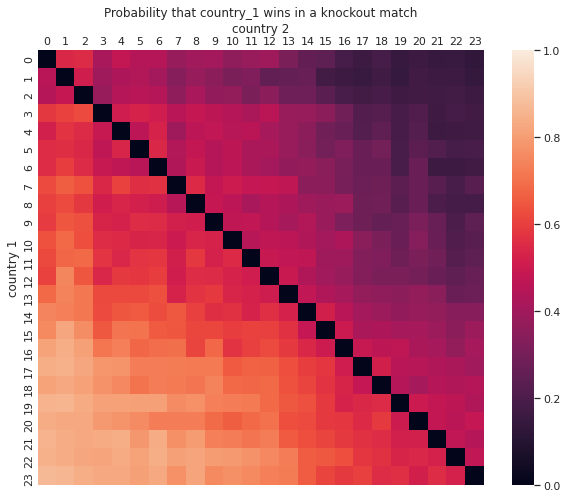

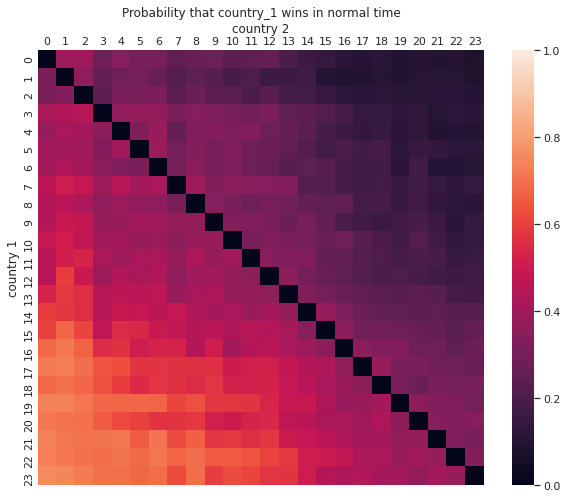

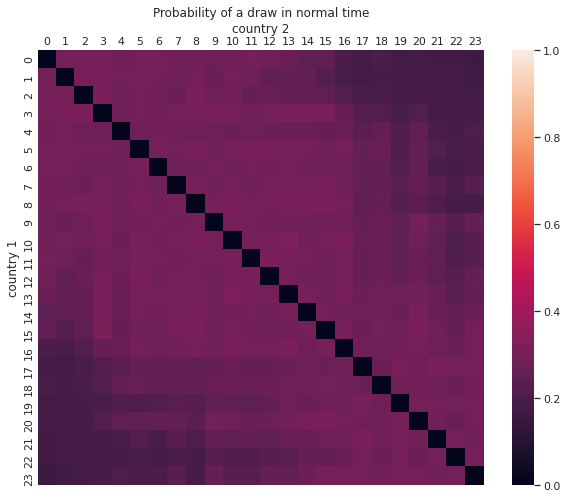

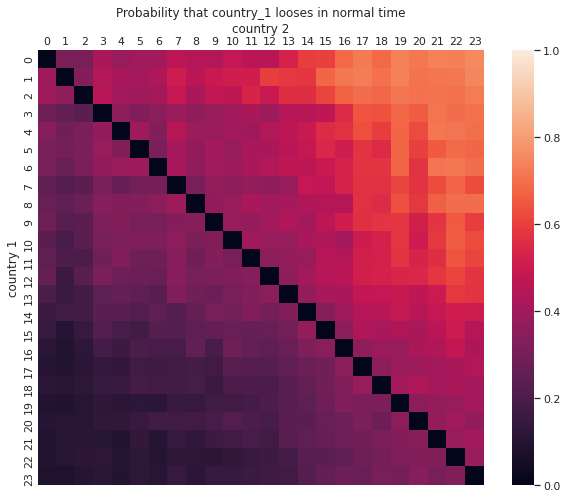

In [6]:
p_knockout_win_matrix = np.zeros(shape=(24, 24))
p_normal_time_win_matrix = np.zeros(shape=(24, 24))
p_normal_time_draw_matrix = np.zeros(shape=(24, 24))
p_normal_time_loss_matrix = np.zeros(shape=(24, 24))

country_id = {country: id for id, country in enumerate(p_match.country_1.unique())}
for index, row in p_match.iterrows():
    c_1, c_2 = country_id[row['country_1']], country_id[row['country_2']]
    p_knockout_win_matrix[c_1, c_2] = row['p_knockout_win']
    p_normal_time_win_matrix[c_1, c_2] = row['p_normal_time_win']
    p_normal_time_draw_matrix[c_1, c_2] = row['p_normal_time_draw']
    p_normal_time_loss_matrix[c_1, c_2] = row['p_normal_time_loss']

plot_matrix(p_knockout_win_matrix, 'Probability that country_1 wins in a knockout match', annot=False)
plot_matrix(p_normal_time_win_matrix, 'Probability that country_1 wins in normal time', annot=False)
plot_matrix(p_normal_time_draw_matrix, 'Probability of a draw in normal time', annot=False)
plot_matrix(p_normal_time_loss_matrix, 'Probability that country_1 looses in normal time', annot=False)

#Single Predictions

In [7]:
country_1 = 'Hungary' #@param ['Hungary', 'North Macedonia', 'Finland', 'Slovakia', 'Ukraine', 'Czech Republic', 'Russia', 'Scotland', 'Wales', 'Turkey', 'Sweden', 'Poland', 'Austria', 'Switzerland', 'Croatia', 'Denmark', 'Netherlands', 'Italy', 'Belgium', 'Germany', 'Portugal', 'Spain', 'England', 'France']
country_2 = 'Germany' #@param ['Hungary', 'North Macedonia', 'Finland', 'Slovakia', 'Ukraine', 'Czech Republic', 'Russia', 'Scotland', 'Wales', 'Turkey', 'Sweden', 'Poland', 'Austria', 'Switzerland', 'Croatia', 'Denmark', 'Netherlands', 'Italy', 'Belgium', 'Germany', 'Portugal', 'Spain', 'England', 'France']

target_p_normal_time_win = target_p_normal_time_draw = target_p_normal_time_loss = None
for index, row in p_match.iterrows():
    if (row['country_1'] == country_1 and row['country_2'] == country_2):
        target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss = \
        row['p_normal_time_win'], row['p_normal_time_draw'], row['p_normal_time_loss']
        break

print('target_p_normal_time_win:', target_p_normal_time_win)
print('target_p_normal_time_draw:', target_p_normal_time_draw)
print('target_p_normal_time_loss:', target_p_normal_time_loss)

target_p_normal_time_win: 0.09
target_p_normal_time_draw: 0.17600000000000002
target_p_normal_time_loss: 0.735


In [8]:
def single_prediction(lambda_1, lambda_2):
    poisson_1, poisson_2 = double_poisson_regression(lambda_1, lambda_2, 0)
    poisson_matrix = to_poisson_matrix(poisson_1, poisson_2)
    p_normal_time_win, p_normal_time_draw, p_normal_time_loss = p_normal_time(poisson_matrix)
    return p_normal_time_win, p_normal_time_draw, p_normal_time_loss

def cross_entropy_loss(prediction, target):
    return -jnp.mean(jnp.stack(target, axis=-1)*jnp.log(jnp.stack(prediction, axis=-1)), axis=-1)

def train_single_prediction(p_normal_time_win, p_normal_time_draw, p_normal_time_loss):
    def get_loss_for_single_prediction(lambda_1, lambda_2):
        return cross_entropy_loss(single_prediction(lambda_1, lambda_2), (p_normal_time_win, p_normal_time_draw, p_normal_time_loss))

    grad_lambda_1 = grad(get_loss_for_single_prediction, argnums=0)
    grad_lambda_2 = grad(get_loss_for_single_prediction, argnums=1)

    lambda_1 = 1.0
    lambda_2 = 1.0

    losses = [get_loss_for_single_prediction(lambda_1, lambda_2)]
    for _ in range(1000):
        #print(lambda_1, lambda_2)

        grad_1 = -grad_lambda_1(lambda_1, lambda_2)
        grad_2 = -grad_lambda_2(lambda_1, lambda_2)

        #print(grad_1, grad_2)

        lambda_1 += grad_1
        lambda_2 += grad_2

        losses.append(get_loss_for_single_prediction(lambda_1, lambda_2))

    return np.array(losses), lambda_1, lambda_2


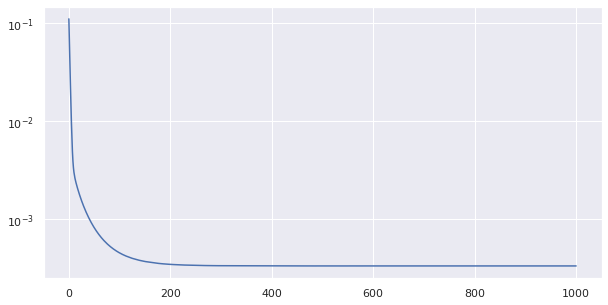

lambda_1: 0.6056743264198303, lambda_2: 2.1659462451934814
0.08990952 0.17582555 0.73426527
0.09 0.17600000000000002 0.735


In [9]:
losses, lambda_1, lambda_2 = train_single_prediction(target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss)
target_entropy = cross_entropy_loss((target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss),
                                    (target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss))
plt.figure(figsize=(10, 5))
plt.semilogy(np.abs(losses - target_entropy))
plt.show()
print(f"lambda_1: {lambda_1}, lambda_2: {lambda_2}")
print(*single_prediction(lambda_1, lambda_2))
print(target_p_normal_time_win, target_p_normal_time_draw, target_p_normal_time_loss)

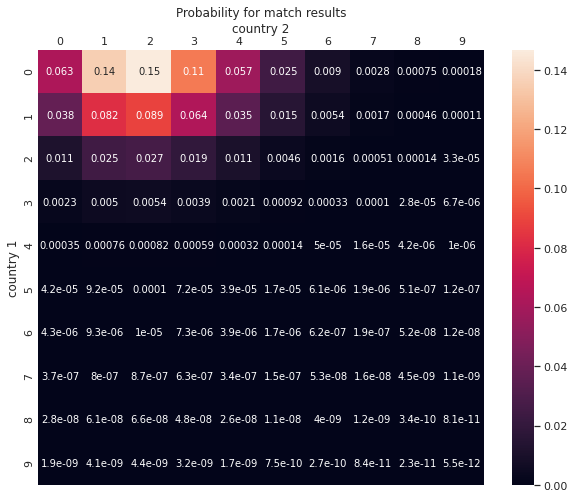

Most probable result is 0:2


In [10]:
poisson_1, poisson_2 = double_poisson_regression(lambda_1, lambda_2, 0)
poisson_matrix = to_poisson_matrix(poisson_1, poisson_2)
plot_matrix(poisson_matrix, 'Probability for match results', vmax=None)

ml_index = np.argmax(poisson_matrix)
print(f"Most probable result is {ml_index//10}:{ml_index%10}")

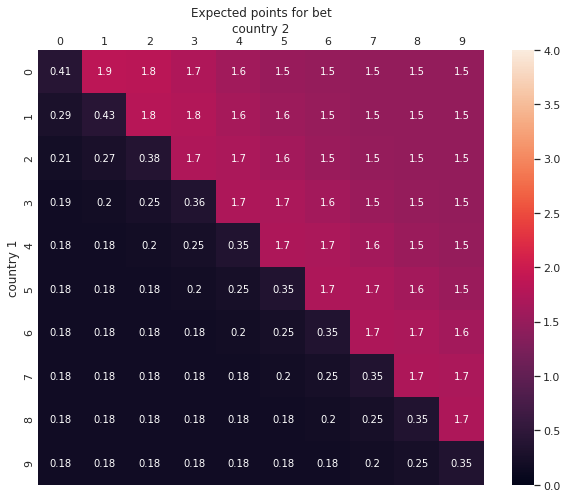

Best bet for Hungary vs. Germany is 0:1


In [11]:
points_matrix = 1*poisson_matrix

points_matrix += 2*win_mask*np.sum(win_mask*poisson_matrix)
points_matrix += 2*draw_mask*np.sum(draw_mask*poisson_matrix)
points_matrix += 2*loss_mask*np.sum(loss_mask*poisson_matrix)

for k in range(-9, 10):
    if k == 0: continue

    diag_shifted = np.eye(10, 10, k=k)
    points_matrix += 1*diag_shifted*np.sum(diag_shifted*poisson_matrix)

plot_matrix(points_matrix, 'Expected points for bet', vmax=4)
best_bet_index = np.argmax(points_matrix)

print(f"Best bet for {country_1} vs. {country_2} is {best_bet_index//10}:{best_bet_index%10}")

# Combined Prediction

In [12]:
def poisson_matrix(lambda_1, lambda_2, max_goals=10):
    lambda_1 = jnp.repeat(jnp.expand_dims(jnp.float32(lambda_1), axis=-1), max_goals, axis=-1)
    lambda_2 = jnp.repeat(jnp.expand_dims(jnp.float32(lambda_2), axis=-1), max_goals, axis=-1)
    
    goals = jnp.arange(max_goals)
    factorials = jnp.cumprod(jnp.maximum(1, jnp.arange(max_goals)))

    poisson_1 = lambda_1**goals*jnp.exp(-lambda_1)/factorials
    poisson_2 = lambda_2**goals*jnp.exp(-lambda_2)/factorials

    poisson_matrix = jnp.dot(jnp.expand_dims(poisson_1, axis=-1), jnp.expand_dims(poisson_2, axis=-2))
    poisson_matrix /= jnp.sum(jnp.sum(poisson_matrix, axis=-1), axis=-1)
    return poisson_matrix

def p_normal_time(poisson_matrix):
    ones_like_matrix = jnp.ones_like(poisson_matrix)
    win_mask = jnp.tril(ones_like_matrix, k=-1)
    draw_mask = jnp.eye(ones_like_matrix.shape[-2])
    loss_mask = jnp.triu(ones_like_matrix, k=1)

    p_normal_time_win = jnp.sum(jnp.sum(poisson_matrix*win_mask, axis=-1), axis=-1)
    p_normal_time_draw = jnp.sum(jnp.sum(poisson_matrix*draw_mask, axis=-1), axis=-1)
    p_normal_time_loss = jnp.sum(jnp.sum(poisson_matrix*loss_mask, axis=-1), axis=-1)

    return p_normal_time_win, p_normal_time_draw, p_normal_time_loss


In [13]:
def single_prediction(lambda_1, lambda_2, max_goals=10):
    return p_normal_time(poisson_matrix(lambda_1, lambda_2, max_goals=max_goals))

def cross_entropy_loss(prediction, target):
    cross_terms = -jnp.mean(jnp.stack(target, axis=-1)*jnp.log(jnp.stack(prediction, axis=-1)), axis=-1)
    return jnp.mean(cross_terms)

combined_prediction = vmap(vmap(single_prediction, in_axes=(0, None), out_axes=0), in_axes=(None, 0), out_axes=1)

In [16]:
def train_combined_prediction(p_normal_time_win_matrix, p_normal_time_draw_matrix, p_normal_time_loss_matrix):
    @jit
    def get_loss_for_combined_prediction(lambdas):
        return cross_entropy_loss(combined_prediction(lambdas, lambdas), (p_normal_time_win_matrix, p_normal_time_draw_matrix, p_normal_time_loss_matrix))

    grad_lambdas = grad(get_loss_for_combined_prediction, argnums=0)

    lambdas = np.ones(24)

    losses = [get_loss_for_combined_prediction(lambdas)]
    for _ in range(10000):
        grads = -grad_lambdas(lambdas)
        lambdas += grads

        losses.append(get_loss_for_combined_prediction(lambdas))

    return np.array(losses), lambdas

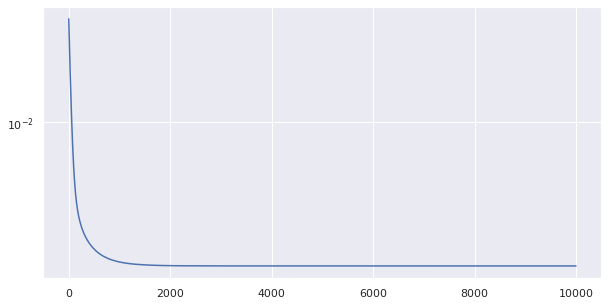

lambdas: [0.66652805 0.57908297 0.63831615 0.8590914  0.81517285 0.8537531
 0.8378655  1.0027201  0.92798966 0.9954849  1.0551283  1.1061076
 1.1171488  1.2361896  1.3512394  1.4759207  1.5913035  1.7799118
 1.7685007  1.9630426  1.8693769  2.0238097  2.1668794  2.1288426 ]


In [17]:
losses, lambdas = train_combined_prediction(p_normal_time_win_matrix, p_normal_time_draw_matrix, p_normal_time_loss_matrix)
target_entropy = cross_entropy_loss((p_normal_time_win_matrix+np.eye(24), p_normal_time_draw_matrix+np.eye(24), p_normal_time_loss_matrix+np.eye(24)),
                                    (p_normal_time_win_matrix, p_normal_time_draw_matrix, p_normal_time_loss_matrix))
plt.figure(figsize=(10, 5))
plt.semilogy(np.abs(losses - target_entropy))
plt.show()
print(f"lambdas: {lambdas}")

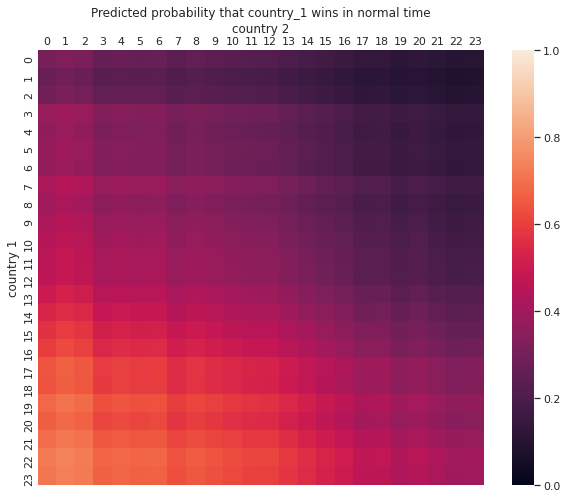

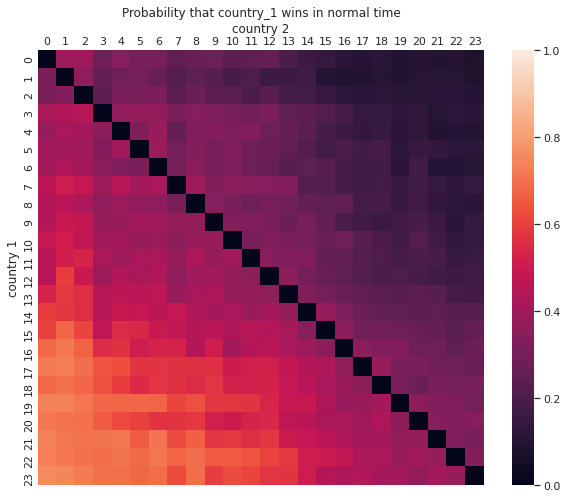

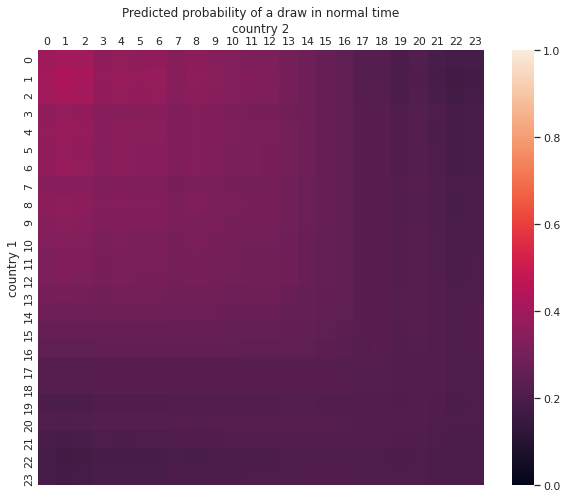

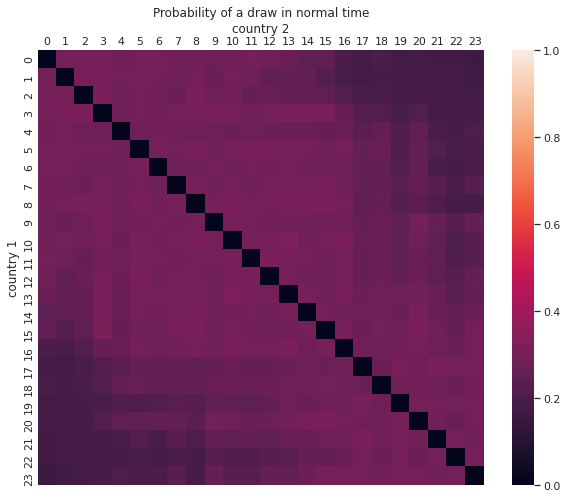

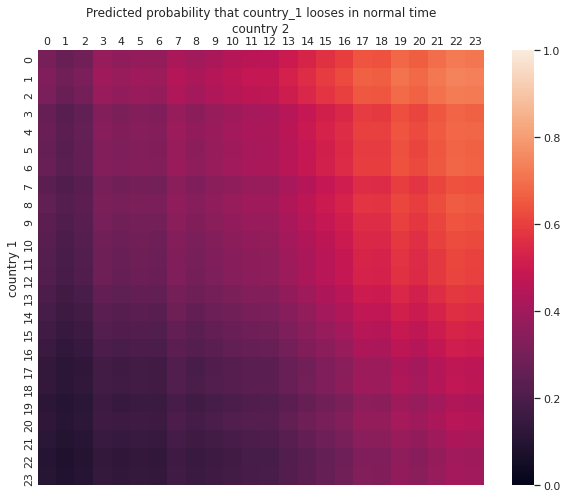

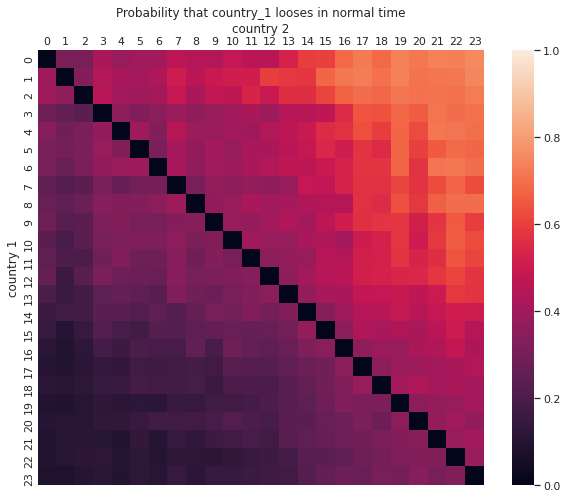

In [18]:
p_normal_time_win_matrix_pred, p_normal_time_draw_matrix_pred, p_normal_time_loss_matrix_pred = combined_prediction(lambdas, lambdas)
plot_matrix(p_normal_time_win_matrix_pred, 'Predicted probability that country_1 wins in normal time', annot=False)
plot_matrix(p_normal_time_win_matrix, 'Probability that country_1 wins in normal time', annot=False)
plot_matrix(p_normal_time_draw_matrix_pred, 'Predicted probability of a draw in normal time', annot=False)
plot_matrix(p_normal_time_draw_matrix, 'Probability of a draw in normal time', annot=False)
plot_matrix(p_normal_time_loss_matrix_pred, 'Predicted probability that country_1 looses in normal time', annot=False)
plot_matrix(p_normal_time_loss_matrix, 'Probability that country_1 looses in normal time', annot=False)

In [19]:
lambdas

DeviceArray([0.66652805, 0.57908297, 0.63831615, 0.8590914 , 0.81517285,
             0.8537531 , 0.8378655 , 1.0027201 , 0.92798966, 0.9954849 ,
             1.0551283 , 1.1061076 , 1.1171488 , 1.2361896 , 1.3512394 ,
             1.4759207 , 1.5913035 , 1.7799118 , 1.7685007 , 1.9630426 ,
             1.8693769 , 2.0238097 , 2.1668794 , 2.1288426 ],            dtype=float32)

#Batched Predictions (using covariance)

In [20]:
covariant_prediction = vmap(vmap(single_prediction, in_axes=(0, 0), out_axes=0), in_axes=(0, 0), out_axes=0)

def train_covariant_prediction(p_normal_time_win_matrix, p_normal_time_draw_matrix, p_normal_time_loss_matrix):
    
    @jit
    def get_loss_for_covariant_prediction(lambda_matrix):
        return cross_entropy_loss(covariant_prediction(lambda_matrix, jnp.transpose(lambda_matrix)), (p_normal_time_win_matrix, p_normal_time_draw_matrix, p_normal_time_loss_matrix))

    grad_lambda_matrix = grad(get_loss_for_covariant_prediction, argnums=0)

    lambda_matrix = np.ones((24, 24))

    losses = [get_loss_for_covariant_prediction(lambda_matrix)]
    for step in range(10000):
        grad_matrix = -grad_lambda_matrix(lambda_matrix)
        lambda_matrix += 10*grad_matrix

        losses.append(get_loss_for_covariant_prediction(lambda_matrix))

    return np.array(losses), lambda_matrix

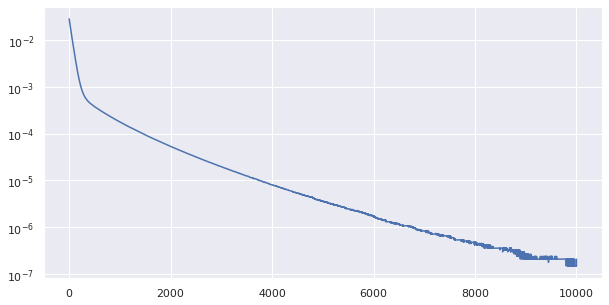

In [21]:
losses, lambda_matrix = train_covariant_prediction(p_normal_time_win_matrix, p_normal_time_draw_matrix, p_normal_time_loss_matrix)
target_entropy = cross_entropy_loss((p_normal_time_win_matrix+np.eye(24), p_normal_time_draw_matrix+np.eye(24), p_normal_time_loss_matrix+np.eye(24)),
                                    (p_normal_time_win_matrix, p_normal_time_draw_matrix, p_normal_time_loss_matrix))
plt.figure(figsize=(10, 5))
plt.semilogy(np.abs(losses - target_entropy))
plt.show()

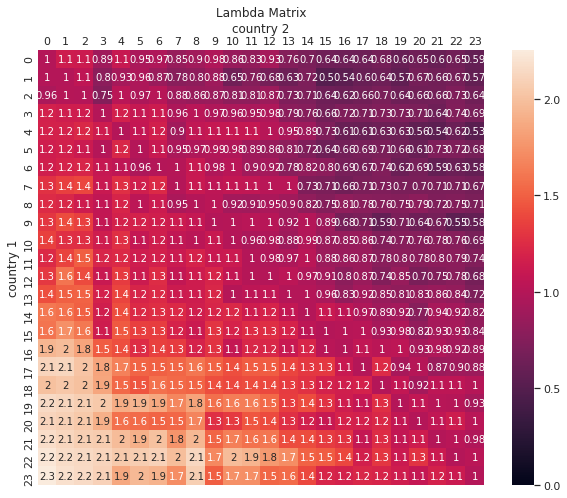

In [22]:
plot_matrix(lambda_matrix, 'Lambda Matrix', vmax=None)

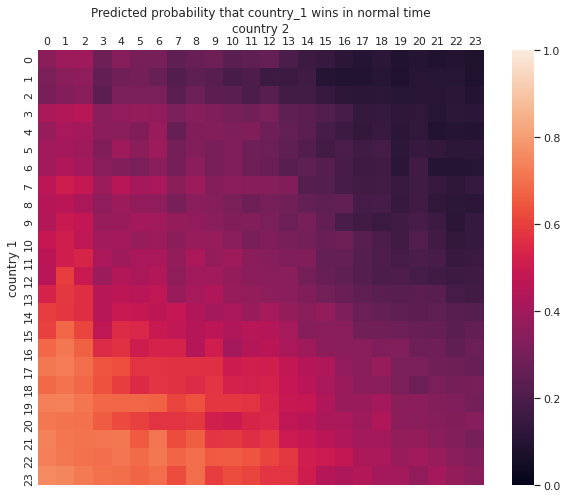

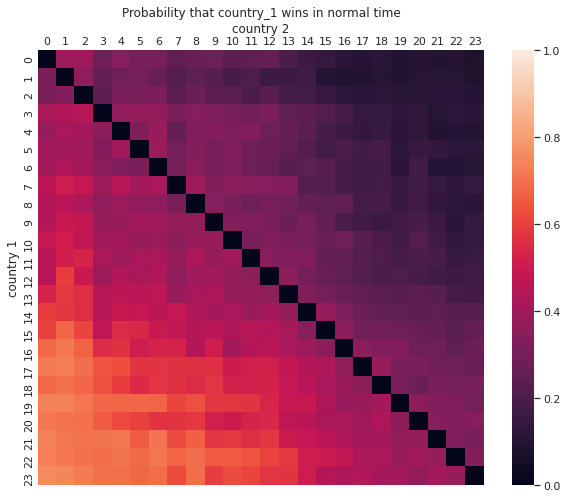

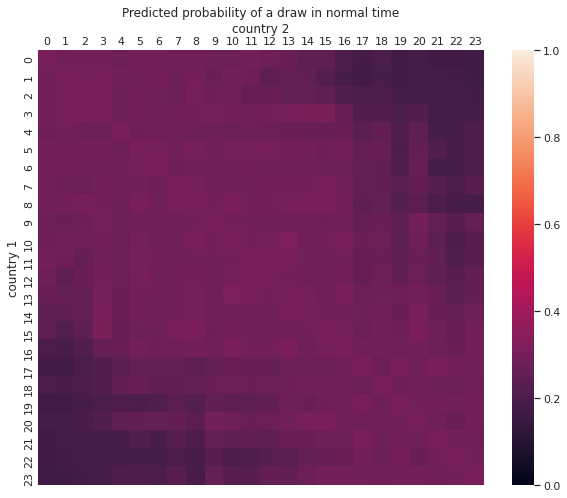

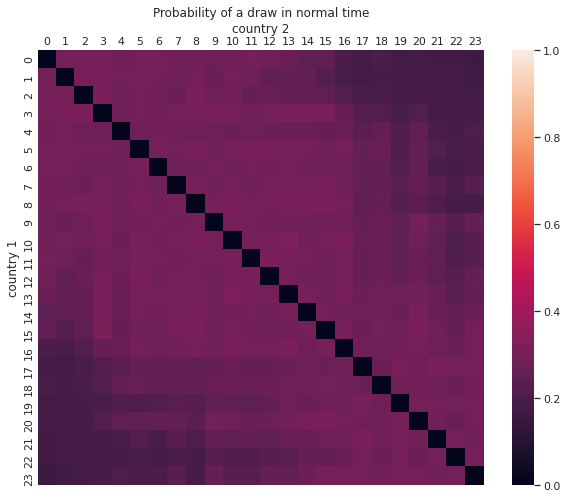

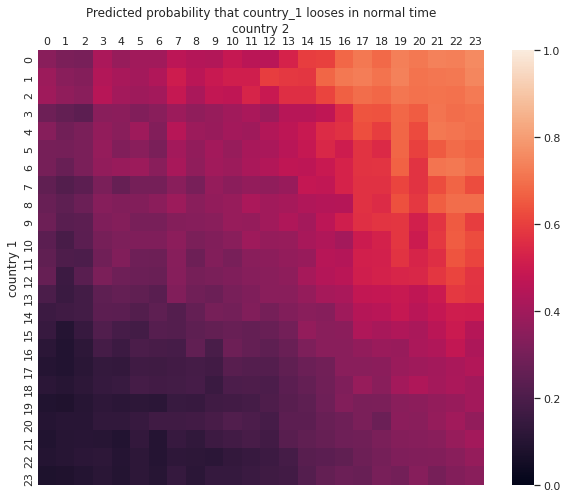

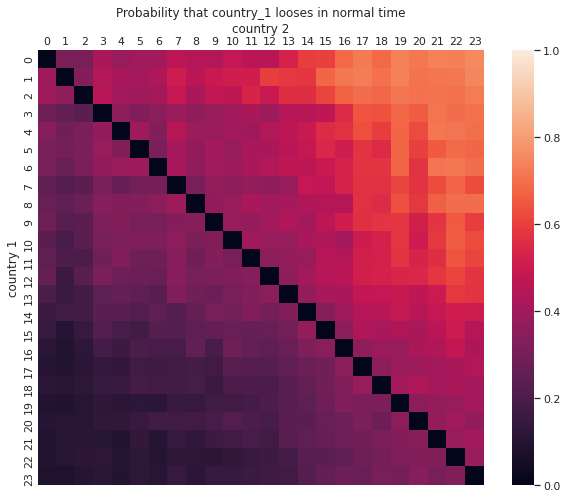

In [23]:
p_normal_time_win_matrix_pred, p_normal_time_draw_matrix_pred, p_normal_time_loss_matrix_pred = covariant_prediction(lambda_matrix, np.transpose(lambda_matrix))
plot_matrix(p_normal_time_win_matrix_pred, 'Predicted probability that country_1 wins in normal time', annot=False)
plot_matrix(p_normal_time_win_matrix, 'Probability that country_1 wins in normal time', annot=False)
plot_matrix(p_normal_time_draw_matrix_pred, 'Predicted probability of a draw in normal time', annot=False)
plot_matrix(p_normal_time_draw_matrix, 'Probability of a draw in normal time', annot=False)
plot_matrix(p_normal_time_loss_matrix_pred, 'Predicted probability that country_1 looses in normal time', annot=False)
plot_matrix(p_normal_time_loss_matrix, 'Probability that country_1 looses in normal time', annot=False)

In [24]:
print("Most probable results:")

for country_1, country_2 in \
[('Turkey', 'Italy'),
('Wales', 'Switzerland'),
('Denmark', 'Finland'),
('Belgium', 'Russia'),
('England', 'Croatia'),
('Austria', 'North Macedonia'),
('Netherlands', 'Ukraine'),
('Scotland', 'Czech Republic'),
('Poland', 'Slovakia'),
('Spain', 'Sweden'),
('Hungary', 'Portugal'),
('France', 'Germany'),
('Finland', 'Russia'),
('Turkey', 'Wales'),
('Italy', 'Switzerland'),
('Ukraine', 'North Macedonia'),
('Denmark', 'Belgium'),
('Netherlands', 'Austria'),
('Sweden', 'Slovakia'),
('Croatia', 'Czech Republic'),
('England', 'Scotland'),
('Hungary', 'France'),
('Portugal', 'Germany'),
('Spain', 'Poland'),
('Italy', 'Wales'),
('Switzerland', 'Turkey'),
('Ukraine', 'Austria'),
('North Macedonia', 'Netherlands'),
('Russia', 'Denmark'),
('Finland', 'Belgium'),
('Croatia', 'Scotland'),
('Czech Republic', 'England'),
('Slovakia', 'Spain'),
('Sweden', 'Poland'),
('Portugal', 'France'),
('Germany', 'Hungary')]:
    c_1 = country_id[country_1]
    c_2 = country_id[country_2]
    poiss_matrix = poisson_matrix(lambda_matrix[c_1, c_2], lambda_matrix[c_2, c_1])
    ml_index = np.argmax(poiss_matrix)
    points_matrix = 1*poiss_matrix

    points_matrix += 2*win_mask*np.sum(win_mask*poiss_matrix)
    points_matrix += 2*draw_mask*np.sum(draw_mask*poiss_matrix)
    points_matrix += 2*loss_mask*np.sum(loss_mask*poiss_matrix)

    for k in range(-9, 10):
        if k == 0: continue

        diag_shifted = np.eye(10, 10, k=k)
        points_matrix += 1*diag_shifted*np.sum(diag_shifted*poiss_matrix)

    best_bet_index = np.argmax(points_matrix)

    print(f"{p_match.country_1[c_1*23].ljust(16)} vs. {p_match.country_1[c_2*23].ljust(16)}: {ml_index//10}:{ml_index%10}", end="")
    if best_bet_index != ml_index:
        print(f" - best bet: {best_bet_index//10}:{best_bet_index%10}")
    else:
        print()

Most probable results:
Turkey           vs. Italy           : 0:1
Wales            vs. Switzerland     : 0:1
Denmark          vs. Finland         : 1:0
Belgium          vs. Russia          : 1:0
England          vs. Croatia         : 1:0
Austria          vs. North Macedonia : 1:0
Netherlands      vs. Ukraine         : 1:0
Scotland         vs. Czech Republic  : 1:0
Poland           vs. Slovakia        : 1:0
Spain            vs. Sweden          : 1:0
Hungary          vs. Portugal        : 0:2 - best bet: 0:1
France           vs. Germany         : 1:0
Finland          vs. Russia          : 1:1 - best bet: 0:1
Turkey           vs. Wales           : 1:1 - best bet: 1:0
Italy            vs. Switzerland     : 1:0
Ukraine          vs. North Macedonia : 1:0
Denmark          vs. Belgium         : 0:1
Netherlands      vs. Austria         : 1:0
Sweden           vs. Slovakia        : 1:0
Croatia          vs. Czech Republic  : 1:0
England          vs. Scotland        : 1:0
Hungary          vs. Franc